# Análise Espectroscópica Robusta

Este notebook segue as melhores práticas da literatura para análise espectroscópica robusta, incluindo:
- Divisão dos dados por Kennard-Stone (70-30)
- Remoção de outliers espectrais (PCA, T²/Q)
- Remoção de outliers dos atributos (boxplot + seaborn)
- Teste de todos os filtros (dependentes e independentes de y)
- Modelagem com PLSR, PCR, RFR, SVMR (hiperparâmetros da literatura)

## 1. Imports

In [2]:
# Imports necessários
import os
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import joblib
from sklearn.metrics import r2_score, mean_squared_error
from scipy.spatial.distance import cdist
from scipy.signal import savgol_filter, detrend
import warnings
from sklearn.pipeline import Pipeline
import time
from sklearn.model_selection import cross_val_predict

# Cria diretórios para organizar todas as imagens salvas
print("Criando diretórios para salvar os gráficos...")
os.makedirs('graficos_outliers_pca', exist_ok=True)
os.makedirs('graficos_outliers_boxplot', exist_ok=True)
os.makedirs('modelos_salvos', exist_ok=True)
# A pasta para os modelos será criada depois, mas podemos garantir aqui
# Nome da pasta para o notebook geral
os.makedirs('graficos_modelos', exist_ok=True) 
# Nome da pasta para o notebook MLPR
os.makedirs('graficos_mlpr', exist_ok=True) 

warnings.filterwarnings('ignore')

# Configurações de plot
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

Criando diretórios para salvar os gráficos...


## 2. Carregamento dos Dados

O primeiro passo em qualquer projeto de ciência de dados é carregar e entender os dados. Nesta seção, realizamos as seguintes ações:
- **Carregamento:** Utilizamos a biblioteca `pandas` para ler o arquivo `dataset_cotton_fruit.xlsx`, que contém os dados espectrais e os valores de referência (atributos físico-químicos).
- **Separação de Dados:** A função `load_data` inteligentemente separa o arquivo em duas partes:
    - `metadata`: Um DataFrame contendo as informações de referência (ex: SST, PH, Firmeza), que serão nossas variáveis-alvo (y).
    - `wavelengths`: Um DataFrame contendo a resposta espectral (absorbância ou reflectância) em cada comprimento de onda, que serão nossas variáveis preditoras (X).
- **Definição de Variáveis:** Convertemos os dados espectrais para um array NumPy (`X`) para otimizar os cálculos e definimos a lista de `atributos` que desejamos modelar.

In [3]:
# Função para carregar dados
def load_data(filepath):
    """Carrega dados espectrais e separa metadados de espectros."""
    df = pd.read_excel(filepath, engine='openpyxl')
    
    # Identificar colunas que são comprimentos de onda (numéricas)
    numeric_cols = []
    for col in df.columns:
        try:
            float(col)
            numeric_cols.append(col)
        except ValueError:
            continue
    
    # Separar metadados e comprimentos de onda
    metadata = df.drop(columns=numeric_cols)
    wavelengths = df[numeric_cols]
    
    return metadata, wavelengths

# Carregar dados
filepath = 'Data/Original/dataset_cotton_fruit.xlsx'
metadata, wavelengths = load_data(filepath)
X = wavelengths.values
wavelength_values = wavelengths.columns.astype(float)
atributos = ['AT', 'FIRMEZA (N)', 'PH', 'SST', 'UBS (%)']

print(f'Dados carregados: {X.shape[0]} amostras, {X.shape[1]} comprimentos de onda')
print(f'Faixa espectral: {wavelength_values.min():.1f} - {wavelength_values.max():.1f} nm')
print(f'Atributos disponíveis: {list(metadata.columns)}')
print(f'Atributos a analisar: {atributos}')

Dados carregados: 250 amostras, 2151 comprimentos de onda
Faixa espectral: 350.0 - 2500.0 nm
Atributos disponíveis: ['Wavelength', 'SST', 'PH', 'AT', 'FIRMEZA (N)', 'UBU (%)', 'UBS (%)']
Atributos a analisar: ['AT', 'FIRMEZA (N)', 'PH', 'SST', 'UBS (%)']


## 3. Divisão dos Dados com Kennard-Stone (70-30)

Para construir um modelo robusto, é crucial dividir os dados em conjuntos de calibração (treino) e validação (teste). Em vez de uma divisão aleatória, usamos o algoritmo **Kennard-Stone (KS)**, que é o padrão-ouro para dados espectrais.
- **Por que Kennard-Stone?** O KS seleciona as amostras para o conjunto de calibração de forma a abranger a máxima variabilidade espectral possível. Ele escolhe as amostras mais diferentes entre si, garantindo que o modelo seja treinado com toda a "diversidade" de espectros presente nos dados.
- **Implementação:**
    - O processo é repetido para cada atributo (`AT`, `PH`, etc.), pois amostras com valores ausentes (`NaN`) são removidas, resultando em conjuntos ligeiramente diferentes para cada modelo.
    - Os dados são padronizados (`StandardScaler`) antes de aplicar o KS para que a distância euclidiana não seja dominada por variáveis de maior escala.
    - Guardamos os índices originais de cada amostra para rastreamento futuro.

In [4]:
def kennard_stone(X, train_size=0.7):
    """Implementa o algoritmo Kennard-Stone para divisão de dados."""
    n_samples = X.shape[0]
    n_train = int(n_samples * train_size)
    
    if n_train < 2:
        raise ValueError("O conjunto de treinamento precisa ter pelo menos duas amostras!")
    
    distances = cdist(X, X, metric='euclidean')
    
    mean_sample = np.mean(X, axis=0)
    first_sample = np.argmax(np.linalg.norm(X - mean_sample, axis=1))
    selected = [first_sample]
    
    remaining = list(range(n_samples))
    remaining.remove(first_sample)
    
    for _ in range(1, n_train):
        dist_to_selected = distances[selected, :]
        min_dist_to_selected = np.min(dist_to_selected[:, remaining], axis=0)
        
        next_sample_idx_in_remaining = np.argmax(min_dist_to_selected)
        next_sample = remaining.pop(next_sample_idx_in_remaining)
        
        selected.append(next_sample)
        
    return np.array(selected), np.array(remaining)

# Divisão para cada atributo
dados_divididos = {}

for atributo in atributos:
    y = metadata[atributo].values
    original_indices = np.arange(len(y)) # Guarda os índices originais
    
    mask = ~np.isnan(y)
    X_clean = X[mask]
    y_clean = y[mask]
    original_indices_clean = original_indices[mask] # Filtra os índices também
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    idx_cal_split, idx_val_split = kennard_stone(X_scaled, train_size=0.7)
    
    X_cal, X_val = X_clean[idx_cal_split], X_clean[idx_val_split]
    y_cal, y_val = y_clean[idx_cal_split], y_clean[idx_val_split]
    
    # Guarda os índices originais de cada conjunto
    indices_orig_cal = original_indices_clean[idx_cal_split]
    indices_orig_val = original_indices_clean[idx_val_split]
    
    dados_divididos[atributo] = {
        'X_cal': X_cal, 'X_val': X_val,
        'y_cal': y_cal, 'y_val': y_val,
        'indices_orig_cal': indices_orig_cal,
        'indices_orig_val': indices_orig_val
    }
    
    print(f'{atributo}: {X_cal.shape[0]} calibração, {X_val.shape[0]} validação')

print(f'\nDivisão Kennard-Stone concluída para {len(atributos)} atributos!')

AT: 175 calibração, 75 validação
FIRMEZA (N): 175 calibração, 75 validação
PH: 175 calibração, 75 validação
SST: 175 calibração, 75 validação
UBS (%): 175 calibração, 75 validação

Divisão Kennard-Stone concluída para 5 atributos!


## 4. Remoção de Outliers Espectrais (PCA, T²/Q) nos Dados de Calibração

Outliers espectrais são amostras cujo espectro é muito diferente do resto da população, podendo ser causados por erros de medição, contaminação ou características únicas da amostra. Eles podem prejudicar significativamente a capacidade de generalização do modelo.
- **Método PCA (T²/Q):** Usamos a Análise de Componentes Principais (PCA) para identificar esses outliers.
    - **Estatística T² (Hotelling's T²):** Mede a variação de uma amostra *dentro* do modelo PCA. Valores altos indicam que a amostra é um outlier na combinação das variáveis principais.
    - **Estatística Q (Resíduos):** Mede a variação da amostra *fora* do modelo PCA (o que o modelo não conseguiu capturar). Valores altos indicam que a estrutura do espectro da amostra é anormal.
- **Lógica:** Uma amostra é considerada outlier se seu valor de T² ou Q ultrapassa um limite de confiança (geralmente 3 desvios padrão da média).
- **Importante:** A remoção de outliers é feita **apenas no conjunto de calibração**. O conjunto de validação deve permanecer intacto para simular dados "reais" que o modelo encontrará no futuro.

In [5]:
def pca_outlier_removal(X, n_components=10, threshold=3):
    """Remove outliers usando PCA com estatísticas T² e Q."""
    # Padronizar dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Aplicar PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Calcular estatística T² (Hotelling's T²)
    T2 = np.sum((X_pca / np.std(X_pca, axis=0)) ** 2, axis=1)
    
    # Calcular estatística Q (resíduos)
    X_reconstructed = pca.inverse_transform(X_pca)
    Q = np.sum((X_scaled - X_reconstructed) ** 2, axis=1)
    
    # Definir limites (média + threshold * desvio padrão)
    T2_limit = np.mean(T2) + threshold * np.std(T2)
    Q_limit = np.mean(Q) + threshold * np.std(Q)
    
    # Identificar outliers
    outliers_mask = (T2 > T2_limit) | (Q > Q_limit)
    
    # Retornamos a máscara de quem NÃO é outlier e o modelo PCA treinado
    return ~outliers_mask, pca, T2, Q, T2_limit, Q_limit

# Remover outliers espectrais dos dados de calibração
dados_pca = {}

for atributo in atributos:
    X_cal = dados_divididos[atributo]['X_cal']
    y_cal = dados_divididos[atributo]['y_cal']
    indices_orig_cal = dados_divididos[atributo]['indices_orig_cal']
    
    # Chama a função de remoção de outliers e armazena todos os resultados
    keep_mask, pca_model, T2, Q, T2_limit, Q_limit = pca_outlier_removal(X_cal)
    
    # Identifica e informa os outliers removidos
    outliers_indices = indices_orig_cal[~keep_mask]
    print(f'{atributo}: {len(outliers_indices)} outliers espectrais removidos da calibração.')
    if len(outliers_indices) > 0:
        print(f'  Índices Originais Removidos: {outliers_indices}')
    
    # Filtra os dados de calibração
    X_cal_clean = X_cal[keep_mask]
    y_cal_clean = y_cal[keep_mask]
    indices_orig_cal_clean = indices_orig_cal[keep_mask]
    
    dados_pca[atributo] = {
        'X_cal': X_cal_clean,
        'y_cal': y_cal_clean,
        'indices_orig_cal': indices_orig_cal_clean,
        'pca_model': pca_model,
        'T2': T2,
        'Q': Q,
        'T2_limit': T2_limit,
        'Q_limit': Q_limit,
        'keep_mask': keep_mask
    }
    
    print(f'  Calibração: {X_cal_clean.shape[0]} amostras')
    print(f'  Validação: {dados_divididos[atributo]["X_val"].shape[0]} amostras')
    print()


AT: 7 outliers espectrais removidos da calibração.
  Índices Originais Removidos: [ 78  74  67  52 237  75  93]
  Calibração: 168 amostras
  Validação: 75 amostras

FIRMEZA (N): 7 outliers espectrais removidos da calibração.
  Índices Originais Removidos: [ 78  74  67  52 237  75  93]
  Calibração: 168 amostras
  Validação: 75 amostras

PH: 7 outliers espectrais removidos da calibração.
  Índices Originais Removidos: [ 78  74  67  52 237  75  93]
  Calibração: 168 amostras
  Validação: 75 amostras

SST: 7 outliers espectrais removidos da calibração.
  Índices Originais Removidos: [ 78  74  67  52 237  75  93]
  Calibração: 168 amostras
  Validação: 75 amostras

UBS (%): 7 outliers espectrais removidos da calibração.
  Índices Originais Removidos: [ 78  74  67  52 237  75  93]
  Calibração: 168 amostras
  Validação: 75 amostras



### 4.1 Verificação de Outliers Espectrais no Conjunto de Validação

Após construir o modelo de PCA com os dados de calibração limpos, podemos usá-lo para avaliar o conjunto de validação. O objetivo aqui **não é remover** amostras da validação, mas sim entender se ele contém amostras que seriam consideradas "estranhas" pelo modelo.
- **Metodologia:**
    1. Padronizamos os dados de validação usando o `scaler` treinado na calibração.
    2. Projetamos esses dados no espaço PCA do modelo de calibração.
    3. Calculamos as estatísticas T² e Q para as amostras de validação.
    4. Comparamos esses valores com os **limites (T²_limit e Q_limit) definidos na calibração**.
- **Interpretação:** Se amostras de validação excederem os limites, isso indica que o modelo pode ter dificuldade em predizê-las, pois elas representam uma variabilidade não vista (ou removida) no treino. Isso é uma informação valiosa sobre a robustez do modelo.

In [6]:
# Verificação de Outliers na Validação
print("--- Verificação de Outliers no Conjunto de Validação ---")
for atributo in atributos:
    # Carrega o modelo PCA e os dados de validação
    pca_model = dados_pca[atributo]['pca_model']
    X_val = dados_divididos[atributo]['X_val']
    indices_orig_val = dados_divididos[atributo]['indices_orig_val']
    
    # Recalcula os limites usando o modelo salvo, se necessário
    # (Ou usa os limites já calculados e salvos anteriormente)
    
    # Padroniza e projeta os dados de validação
    scaler_val = StandardScaler().fit(dados_divididos[atributo]['X_cal']) # Usa o scaler da calibração
    X_val_scaled = scaler_val.transform(X_val)
    X_val_pca = pca_model.transform(X_val_scaled)

    # Calcula T² e Q para a validação
    T2_val = np.sum((X_val_pca / np.std(X_val_pca, axis=0)) ** 2, axis=1)
    X_val_reconstructed = pca_model.inverse_transform(X_val_pca)
    Q_val = np.sum((X_val_scaled - X_val_reconstructed) ** 2, axis=1)

    # Identifica outliers da validação usando os limites da CALIBRAÇÃO
    outliers_val_mask = (T2_val > T2_limit) | (Q_val > Q_limit)
    outliers_val_indices = indices_orig_val[outliers_val_mask]
    
    print(f'\nAtributo: {atributo}')
    if len(outliers_val_indices) > 0:
        print(f'  {len(outliers_val_indices)} amostras de VALIDAÇÃO excedem os limites da calibração.')
        print(f'  Índices Originais: {outliers_val_indices}')
    else:
        print('  Nenhuma amostra de validação excede os limites da calibração.')

--- Verificação de Outliers no Conjunto de Validação ---

Atributo: AT
  Nenhuma amostra de validação excede os limites da calibração.

Atributo: FIRMEZA (N)
  Nenhuma amostra de validação excede os limites da calibração.

Atributo: PH
  Nenhuma amostra de validação excede os limites da calibração.

Atributo: SST
  Nenhuma amostra de validação excede os limites da calibração.

Atributo: UBS (%)
  Nenhuma amostra de validação excede os limites da calibração.


### 4.2 Gráficos de Outliers T² e Q

In [7]:
for atributo in atributos:
    d = dados_pca[atributo][0]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico 1: Variância explicada cumulativa
    # Acessa o modelo PCA com a chave correta 'pca_model'
    cumulative_variance = np.cumsum(d['pca_model'].explained_variance_ratio_)
    axes[0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', linewidth=2, markersize=6)
    axes[0].set_xlabel('Número de Componentes Principais')
    axes[0].set_ylabel('Variância Explicada Cumulativa')
    axes[0].set_title(f'Variância Explicada - {atributo}')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95%')
    axes[0].legend()
    
    # Gráfico 2: T² vs Q (detecção de outliers)
    # Acessa as variáveis T2, Q, T2_limit, Q_limit e keep_mask com as chaves corretas
    scatter = axes[1].scatter(d['T2'], d['Q'], c=d['keep_mask'], cmap='coolwarm', 
                              edgecolor='k', alpha=0.7, s=50)
    axes[1].axhline(d['Q_limit'], color='r', linestyle='--', linewidth=2, label=f'Q Limit: {d["Q_limit"]:.2f}')
    axes[1].axvline(d['T2_limit'], color='g', linestyle='--', linewidth=2, label=f'T² Limit: {d["T2_limit"]:.2f}')
    axes[1].set_xlabel("Hotelling's T²")
    axes[1].set_ylabel('Q Residual')
    axes[1].set_title(f'Detecção de Outliers - {atributo}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Adicionar legenda de cores (esta parte também foi ajustada para a chave 'keep_mask')
    legend1 = axes[1].legend(*scatter.legend_elements(), title="Status")
    axes[1].add_artist(legend1)
    
    plt.tight_layout()
    plt.show()
    
    print(f'Gráficos de outliers para {atributo} exibidos.')
    print()

KeyError: 0

## 5. Remoção de Outliers dos Atributos (Boxplot + Seaborn)

Além dos outliers espectrais (em X), podemos ter outliers nos valores de referência (em y). Por exemplo, um valor de pH ou SST que é analiticamente improvável ou resultado de um erro de anotação.
- **Método (IQR):** O método do Intervalo Interquartil (IQR) é uma forma estatística robusta de identificar esses pontos.
    - `IQR = Q3 (percentil 75) - Q1 (percentil 25)`
    - Um valor é considerado outlier se estiver abaixo de `Q1 - 1.5 * IQR` ou acima de `Q3 + 1.5 * IQR`.
- **Visualização:** O `boxplot` é a ferramenta visual perfeita para essa análise, pois ele desenha os "bigodes" exatamente nesses limites de 1.5 * IQR, mostrando os outliers como pontos individuais.
- **Ação:** Novamente, a remoção é feita apenas no conjunto de calibração.

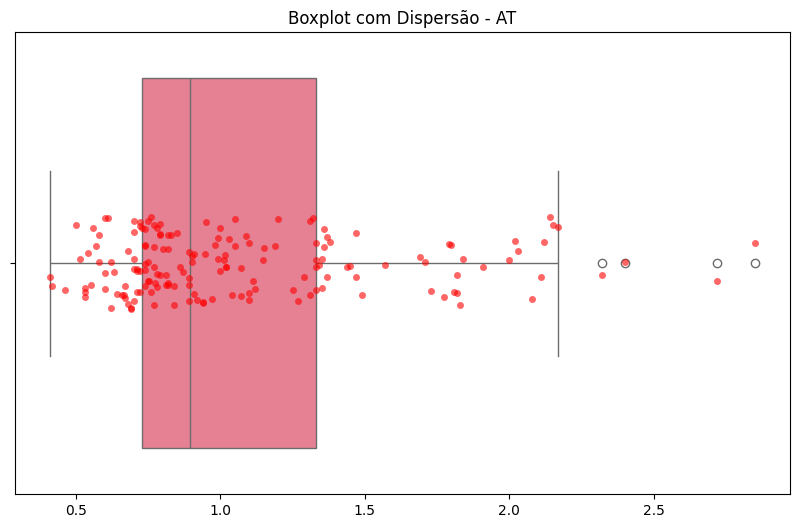

AT: 4 outliers de atributo removidos.
  Índices Originais Removidos: [15 12 30 19]
  Calibração final: 164 amostras
  Validação: 75 amostras



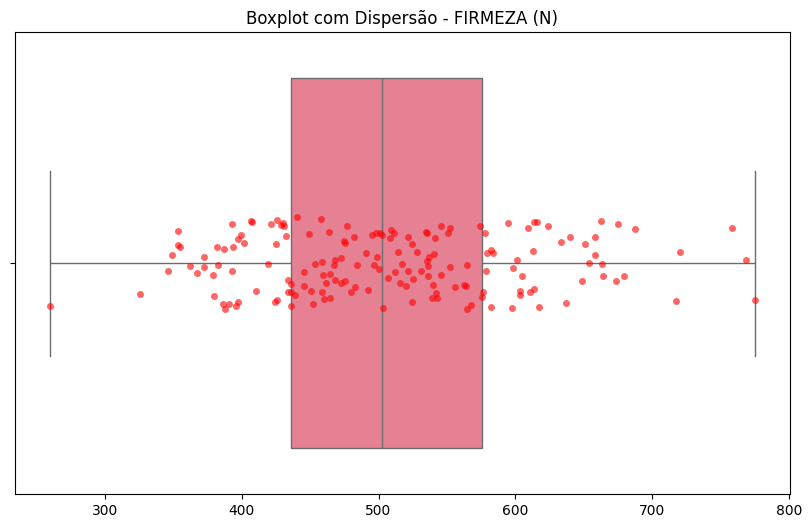

FIRMEZA (N): 0 outliers de atributo removidos.
  Calibração final: 168 amostras
  Validação: 75 amostras



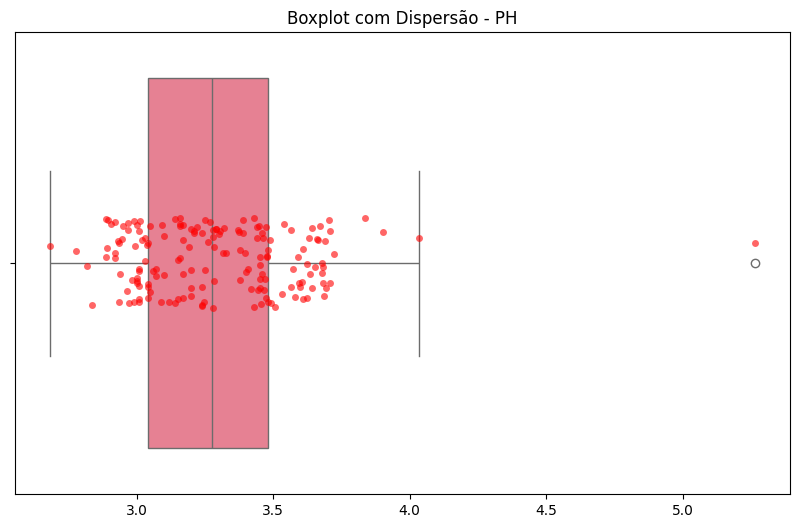

PH: 1 outliers de atributo removidos.
  Índices Originais Removidos: [56]
  Calibração final: 167 amostras
  Validação: 75 amostras



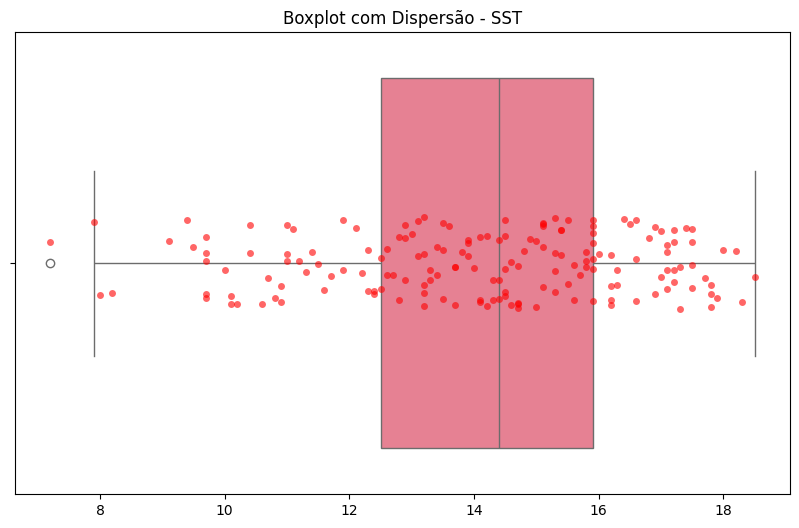

SST: 1 outliers de atributo removidos.
  Índices Originais Removidos: [30]
  Calibração final: 167 amostras
  Validação: 75 amostras



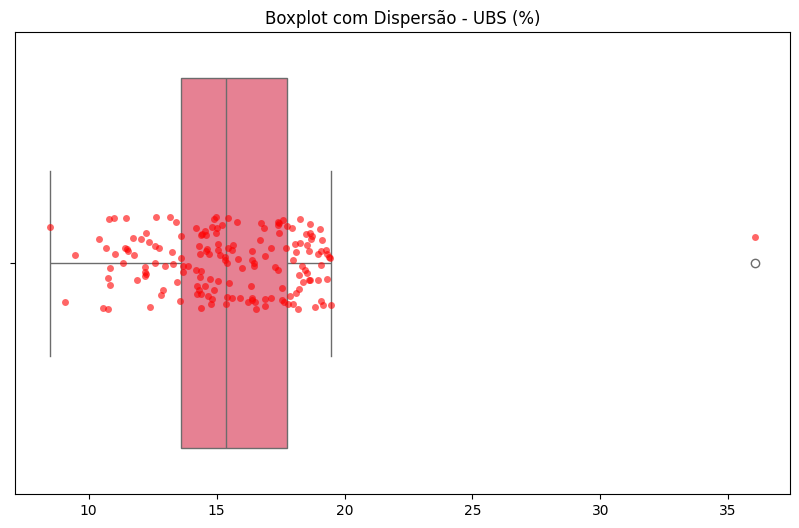

UBS (%): 1 outliers de atributo removidos.
  Índices Originais Removidos: [242]
  Calibração final: 167 amostras
  Validação: 75 amostras



In [ ]:
# Remover outliers dos atributos usando boxplot e IQR
dados_final = {}

for atributo in atributos:
    # Pega os dados já limpos de outliers espectrais
    d = dados_pca[atributo]
    X_cal = d['X_cal']
    y_cal = d['y_cal']
    indices_orig_cal = d['indices_orig_cal']
    
    # Boxplot (seu código de plotagem original pode ser mantido aqui)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=y_cal)
    sns.stripplot(x=y_cal, color='red', alpha=0.6)
    plt.title(f'Boxplot com Dispersão - {atributo}')
    
    nome_arquivo = f'graficos_outliers_boxplot/boxplot_outliers_{atributo}.png'
    plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')
    
    plt.show()

    # Lógica de remoção de outliers
    Q1 = np.percentile(y_cal, 25)
    Q3 = np.percentile(y_cal, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    keep_mask_attr = (y_cal >= lower_bound) & (y_cal <= upper_bound)
    
    # Identifica e informa os outliers removidos
    outliers_attr_indices = indices_orig_cal[~keep_mask_attr]
    print(f'{atributo}: {len(outliers_attr_indices)} outliers de atributo removidos.')
    if len(outliers_attr_indices) > 0:
        print(f'  Índices Originais Removidos: {outliers_attr_indices}')
    
    # Armazena os dados finais e limpos para modelagem
    dados_final[atributo] = {
        'X_cal': X_cal[keep_mask_attr],
        'y_cal': y_cal[keep_mask_attr],
        'X_val': dados_divididos[atributo]['X_val'], # Validação original
        'y_val': dados_divididos[atributo]['y_val']   # Validação original
    }
    
    print(f'  Calibração final: {dados_final[atributo]["X_cal"].shape[0]} amostras')
    print(f'  Validação: {dados_final[atributo]["X_val"].shape[0]} amostras')
    print()

## 6. Filtros de Pré-processamento (Independentes e Dependentes de y)

Os dados espectrais brutos contêm diversas fontes de variação indesejada que podem mascarar a informação química relevante. Essas variações podem ser causadas por espalhamento de luz (efeitos físicos da amostra), mudanças na linha de base (drift do instrumento) e ruído. O pré-processing visa minimizar esses efeitos para que o modelo foque na correlação entre o espectro e o atributo de interesse.

Neste notebook, testamos uma ampla gama de filtros, divididos em duas categorias:

### Filtros Independentes de y

São aplicados apenas aos espectros (`X`) e não utilizam a informação da variável alvo (`y`).

-   **`Raw`**: Utiliza os dados espectrais brutos, sem nenhum tratamento. Serve como uma linha de base para comparar a eficácia dos outros filtros.
-   **`MSC` (Multiplicative Scatter Correction)**: Corrige o espalhamento de luz (aditivo e multiplicativo) causado por variações no tamanho de partícula e compactação da amostra. Ele ajusta cada espectro para se parecer mais com um espectro "ideal" (geralmente a média de todos os espectros).
-   **`SNV` (Standard Normal Variate)**: Alternativa ao MSC que também corrige o espalhamento de luz. A diferença é que o SNV padroniza cada espectro individualmente (subtrai a média e divide pelo desvio padrão daquele espectro), sem usar um espectro de referência.
-   **`SG_D1` e `SG_D2` (Savitzky-Golay Derivatives)**: Calcula a primeira ou a segunda derivada do espectro. Derivadas são excelentes para remover desvios de linha de base (efeitos aditivos) e para resolver picos espectrais sobrepostos, realçando a informação de bandas de absorção específicas.
-   **`Detrend`**: Remove tendências lineares ou polinomiais da linha de base do espectro. É muito eficaz para corrigir "inclinações" no espectro causadas por drift do instrumento.
-   **`Normalize`**: Realiza uma normalização Min-Max, escalonando a intensidade de cada espectro para um intervalo fixo (geralmente [0, 1]). Ajuda a corrigir variações de intensidade causadas por diferenças na distância da amostra ou na potência da fonte de luz.
-   **`EMSC` (Extended Multiplicative Signal Correction)**: Uma versão avançada do MSC. Além de corrigir os efeitos de espalhamento, o EMSC pode incluir termos polinomiais para modelar e remover efeitos de linha de base mais complexos e não-lineares.
-   **`Continuum Removal`**: Técnica que normaliza os espectros para que as bandas de absorção possam ser comparadas em termos de sua profundidade, e não de sua intensidade absoluta. Ele ajusta um "envelope" (casco convexo) sobre o espectro e divide o espectro original por este envelope, realçando as características de absorção.
-   **`Wavelet_Denoising`**: Utiliza a Transformada Wavelet para decompor o espectro em diferentes níveis de frequência. A técnica permite remover o ruído (geralmente presente em altas frequências) de forma muito eficaz, preservando as principais características do sinal espectral.

### Filtros Dependentes de y e Combinações

Estes filtros utilizam a variável alvo (`y`) para otimizar a remoção de variação não correlacionada em `X`, ou são combinações sequenciais de múltiplos filtros para um tratamento mais completo.

-   **`OSC_1` e `OSC_2` (Orthogonal Signal Correction)**: Filtro que remove componentes (1 ou 2, neste caso) dos espectros `X` que são ortogonais (não correlacionados) à variável alvo `y`. O objetivo é limpar `X` da variação que não ajuda na predição, potencialmente melhorando o modelo subsequente. Esta técnica é frequentemente referida como um pré-processamento **OPLS** (Orthogonal Projections to Latent Structures).
-   **`MSC_SG_OSC`**: Uma **cadeia de pré-processamentos** aplicada na seguinte ordem:
    1.  `MSC` para corrigir o espalhamento.
    2.  `Savitzky-Golay (1ª derivada)` para corrigir a linha de base.
    3.  `OSC (1 componente)` para remover variação não correlacionada com `y`.
-   **`OPLS1_SNV_SG_D1` e `OPLS2_SNV_SG_D1`**: Outra cadeia de processamento:
    1.  `SNV` para correção de espalhamento.
    2.  `Savitzky-Golay (1ª derivada)`.
    3.  `OPLS/OSC` para remover 1 ou 2 componentes ortogonais a `y`.
-   **`SNV_Detrend_SG_D1`**: Uma combinação de filtros independentes de `y`, mas que, por sua complexidade, é testada junto às outras cadeias:
    1.  `SNV`.
    2.  `Detrend` para remoção de tendência.
    3.  `Savitzky-Golay (1ª derivada)`.

In [ ]:
# Implementação dos filtros de pré-processamento
# Filtros independentes de y
def msc(X):
    """Multiplicative Scatter Correction."""
    X = np.asarray(X)
    mean_spectrum = np.mean(X, axis=0)
    corrected_spectra = np.zeros_like(X)
    for i in range(X.shape[0]):
        slope, intercept = np.polyfit(mean_spectrum, X[i, :], 1)
        corrected_spectra[i, :] = (X[i, :] - intercept) / slope
    return corrected_spectra

def snv(X):
    """Standard Normal Variate."""
    X = np.asarray(X)
    return (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

def savitzky_golay(X, window_size=11, poly_order=2, deriv_order=1):
    """Savitzky-Golay filter."""
    return savgol_filter(X, window_length=window_size, polyorder=poly_order, deriv=deriv_order, axis=1)

def detrend_filter(X):
    """Detrending filter."""
    return detrend(X, axis=1)

def normalize(X):
    """Normalização Min-Max."""
    return (X - np.min(X, axis=1, keepdims=True)) / (np.max(X, axis=1, keepdims=True) - np.min(X, axis=1, keepdims=True))

def emsc(X, reference=None):
    """Extended Multiplicative Signal Correction."""
    X = np.asarray(X)
    if reference is None:
        reference = np.mean(X, axis=0)  # Usa o espectro médio como referência
    
    X_corr = np.zeros_like(X)
    for i in range(X.shape[0]):
        # Modelo: X[i] ≈ a + b*reference
        model = np.vstack([np.ones_like(reference), reference]).T
        params, _, _, _ = np.linalg.lstsq(model, X[i, :], rcond=None)
        a, b = params[0], params[1]
        X_corr[i,:] = (X[i, :] - a) / b
    return X_corr

def continuum_removal(X, wavelengths):
    """Continuum Removal."""
    X = np.asarray(X)
    X_cr = np.zeros_like(X)
    for i in range(X.shape[0]):
        spectrum = X[i, :]
        # Encontra os pontos do casco convexo superior
        q_u = [0]
        for k in range(1, len(wavelengths) - 1):
            s_k = (spectrum[len(wavelengths)-1] - spectrum[0]) / (wavelengths[-1] - wavelengths[0])
            s_q = (spectrum[k] - spectrum[q_u[-1]]) / (wavelengths[k] - wavelengths[q_u[-1]])
            if s_q > s_k:
                q_u.append(k)
        q_u.append(len(wavelengths)-1)
        
        # Interpolação linear entre os pontos do casco
        continuum = np.interp(wavelengths, wavelengths[q_u], spectrum[q_u])
        X_cr[i, :] = spectrum / continuum
    return X_cr

def wavelet_denoising(X, wavelet='db4', level=4):
    """Wavelet Transform para Denoising."""
    X = np.asarray(X)
    original_length = X.shape[1]
    denoised_list = []

    for i in range(X.shape[0]):
        # 1. Decomposição Wavelet
        coeffs = pywt.wavedec(X[i, :], wavelet, level=level)

        # 2. Cálculo do limiar (threshold)
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(original_length))

        # 3. Aplicação do filtro (soft thresholding) nos coeficientes de detalhe
        coeffs[1:] = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]

        # 4. Reconstrução do sinal
        reconstructed_signal = pywt.waverec(coeffs, wavelet)

        # 5. Ajuste do tamanho
        denoised_list.append(reconstructed_signal[:original_length])

    return np.asarray(denoised_list)

# Filtros dependentes de y (Orthogonal Signal Correction)
class OrthogonalCorrection:
    """Orthogonal Signal Correction (OSC)."""
    def __init__(self, n_components=1):
        self.n_components = n_components
    
    def fit_transform(self, X, y):
        X, y = np.asarray(X), np.asarray(y).ravel()
        self.w_ortho_ = []
        self.p_ortho_ = []
        self.X_corr_ = X.copy()
        
        for _ in range(self.n_components):
            pls = PLSRegression(n_components=1)
            pls.fit(self.X_corr_, y)
            t = pls.x_scores_
            w = pls.x_weights_
            p = pls.x_loadings_
            
            # Componente Ortogonal
            w_ortho = p - (np.dot(w.T, p) / np.dot(w.T, w)) * w
            t_ortho = np.dot(self.X_corr_, w_ortho)
            p_ortho = np.dot(t_ortho.T, self.X_corr_) / np.dot(t_ortho.T, t_ortho)
            
            # Remover variação ortogonal
            self.X_corr_ -= np.dot(t_ortho, p_ortho)
            self.w_ortho_.append(w_ortho)
            self.p_ortho_.append(p_ortho)
        
        return self.X_corr_
    
    def transform(self, X):
        X_res = np.asarray(X).copy()
        for i in range(self.n_components):
            t_ortho = np.dot(X_res, self.w_ortho_[i])
            X_res -= np.dot(t_ortho, self.p_ortho_[i])
        return X_res

# Dicionário de filtros independentes de y
filtros_independentes = {
    'Raw': lambda X: X,
    'MSC': msc,
    'SNV': snv,
    'SG_D1': lambda X: savitzky_golay(X, window_size=11, poly_order=2, deriv_order=1),
    'SG_D2': lambda X: savitzky_golay(X, window_size=11, poly_order=2, deriv_order=2),
    'Detrend': detrend_filter,
    'Normalize': normalize,
    'EMSC': emsc,
    'Continuum_Removal': lambda X: continuum_removal(X, wavelength_values),
    'Wavelet_Denoising': wavelet_denoising
}

# Dicionário de filtros dependentes de y
filtros_dependentes = {
    'OSC_1': lambda X, y: OrthogonalCorrection(n_components=1).fit_transform(X, y),
    'OSC_2': lambda X, y: OrthogonalCorrection(n_components=2).fit_transform(X, y),
    'MSC_SG_OSC': lambda X, y: OrthogonalCorrection(n_components=1).fit_transform(
        savitzky_golay(msc(X), window_size=11, poly_order=2, deriv_order=1), y),
    'OPLS1_SNV_SG_D1': lambda X, y: OrthogonalCorrection(n_components=1).fit_transform(
        savitzky_golay(snv(X), window_size=11, poly_order=2, deriv_order=1), y),
    'OPLS2_SNV_SG_D1': lambda X, y: OrthogonalCorrection(n_components=2).fit_transform(
        savitzky_golay(snv(X), window_size=11, poly_order=2, deriv_order=1), y),
    'SNV_Detrend_SG_D1': lambda X, y: savitzky_golay(detrend_filter(snv(X)), window_size=11, poly_order=2, deriv_order=1)
}

print(f'Filtros independentes de y: {list(filtros_independentes.keys())}')
print(f'Filtros dependentes de y: {list(filtros_dependentes.keys())}')
print(f'Total de filtros: {len(filtros_independentes) + len(filtros_dependentes)}')

Filtros independentes de y: ['Raw', 'MSC', 'SNV', 'SG_D1', 'SG_D2', 'Detrend', 'Normalize', 'EMSC', 'Continuum_Removal', 'Wavelet_Denoising']
Filtros dependentes de y: ['OSC_1', 'OSC_2', 'MSC_SG_OSC', 'OPLS1_SNV_SG_D1', 'OPLS2_SNV_SG_D1', 'SNV_Detrend_SG_D1']
Total de filtros: 16


In [ ]:
print("Shape de X:", X.shape)
print("Shape de wavelengths:", wavelengths.shape)

Shape de X: (250, 2151)
Shape de wavelengths: (250, 2151)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_filtros_independentes(X, wavelengths_values, filtros_independentes):
    """
    Plota os gráficos dos filtros independentes aplicados ao dataset, salvando uma imagem separada para cada filtro.

    Parâmetros:
    - X: np.ndarray, dados espectrais originais (amostras x comprimentos de onda).
    - wavelengths_values: np.ndarray, valores dos comprimentos de onda.
    - filtros_independentes: dict, dicionário de funções de filtros independentes.

    Retorno:
    - Salva uma imagem para cada filtro aplicado.
    """
    for nome_filtro, func_filtro in filtros_independentes.items():
        # Aplica o filtro
        X_filtrado = func_filtro(X)

        # Cria a figura para o filtro atual
        plt.figure(figsize=(10, 6))
        for espectro in X_filtrado:
            plt.plot(wavelengths_values, espectro, alpha=0.7)
        plt.title(f"Filtro: {nome_filtro}", fontsize=14)
        plt.xlabel("Comprimento de Onda (nm)", fontsize=12)
        plt.ylabel("Intensidade", fontsize=12)
        plt.grid(True)

        # Salva a figura
        plt.savefig(f"grafico_{nome_filtro}.png")
        plt.close()

In [ ]:
# Depuração dos dados de entrada
print("Formato de X:", X.shape)
print("Primeiros valores de X:", X[:5])
print("Formato de wavelengths_values:", wavelength_values.shape)
print("Primeiros valores de wavelengths_values:", wavelength_values[:5])
print("Chaves de filtros_independentes:", list(filtros_independentes.keys()))

Formato de X: (250, 2151)
Primeiros valores de X: [[0.12147462 0.1339322  0.12126856 ... 0.01877304 0.0187442  0.0175124 ]
 [0.22830937 0.22503523 0.23509654 ... 0.0261977  0.02666582 0.02573513]
 [0.16015423 0.15416337 0.15199672 ... 0.01907885 0.02003937 0.02314041]
 [0.11125468 0.1129544  0.11684808 ... 0.01258329 0.01229228 0.01341544]
 [0.17437007 0.16852736 0.14880459 ... 0.01777379 0.0179632  0.01829009]]
Formato de wavelengths_values: (2151,)
Primeiros valores de wavelengths_values: Index([350.0, 351.0, 352.0, 353.0, 354.0], dtype='float64')
Chaves de filtros_independentes: ['Raw', 'MSC', 'SNV', 'SG_D1', 'SG_D2', 'Detrend', 'Normalize', 'EMSC', 'Continuum_Removal', 'Wavelet_Denoising']


In [ ]:
# Teste individual dos filtros
for nome_filtro, func_filtro in filtros_independentes.items():
    try:
        print(f"Testando filtro: {nome_filtro}")
        X_filtrado = func_filtro(X)
        print(f"Formato do resultado do filtro {nome_filtro}: {X_filtrado.shape}")
        print(f"Primeiros valores do filtro {nome_filtro}: {X_filtrado[:2, :5]}")
    except Exception as e:
        print(f"Erro ao aplicar o filtro {nome_filtro}: {e}")

Testando filtro: Raw
Formato do resultado do filtro Raw: (250, 2151)
Primeiros valores do filtro Raw: [[0.12147462 0.1339322  0.12126856 0.13874773 0.12438013]
 [0.22830937 0.22503523 0.23509654 0.23479082 0.24156452]]
Testando filtro: MSC
Formato do resultado do filtro MSC: (250, 2151)
Primeiros valores do filtro MSC: [[0.17098259 0.18890884 0.17068607 0.19583832 0.17516356]
 [0.23694882 0.23339252 0.24432091 0.24398884 0.25134629]]
Testando filtro: SNV
Formato do resultado do filtro SNV: (250, 2151)
Primeiros valores do filtro SNV: [[1.05770422 1.28631947 1.05392263 1.37469172 1.11102461]
 [1.91149376 1.86584098 2.00613037 2.00186755 2.09631634]]
Testando filtro: SG_D1
Formato do resultado do filtro SG_D1: (250, 2151)
Primeiros valores do filtro SG_D1: [[-0.00257222 -0.00175058 -0.00092893 -0.00010729  0.00071435]
 [ 0.008233    0.00745724  0.00668149  0.00590573  0.00512998]]
Testando filtro: SG_D2
Formato do resultado do filtro SG_D2: (250, 2151)
Primeiros valores do filtro SG_D2: 

In [1]:
# Teste da função de plotagem
plot_filtros_independentes(X, wavelength_values, filtros_independentes)

NameError: name 'plot_filtros_independentes' is not defined

## 7. Avaliação dos Filtros e Seleção dos Melhores

Nesta etapa crucial, construímos e avaliamos os modelos de regressão. Em vez de testar cada modelo separadamente, criamos um fluxo automatizado e exaustivo para garantir que encontremos a melhor performance possível.
- **Estratégia:**
    1. **Iteração por Atributo:** Um loop externo passa por cada variável alvo (AT, PH, etc.).
    2. **Iteração por Modelo:** Para cada atributo, testamos uma lista de modelos quimiométricos:
        - `PLSR`: Padrão da área, lida bem com multicolinearidade.
        - `PCR`: Alternativa que primeiro reduz a dimensionalidade.
        - `RFR` (Random Forest): Modelo não-linear, robusto e poderoso.
        - `SVMR` (Support Vector Machine): Eficaz em espaços de alta dimensão.
    3. **Iteração por Filtro:** Para cada modelo, aplicamos **todos os 16 filtros** de pré-processamento definidos na seção anterior.
    4. **Otimização (GridSearchCV):** Para cada combinação `(atributo, modelo, filtro)`, usamos `GridSearchCV` com validação cruzada (10-fold) para encontrar os melhores hiperparâmetros do modelo (ex: número de componentes para PLS, parâmetros C e gamma para SVM).
- **Avaliação:** O desempenho de cada combinação é medido pelo R² da validação cruzada. O melhor modelo é então treinado com todos os dados de calibração e sua performance final é avaliada no conjunto de validação, que foi mantido separado durante todo o processo.
- **Saídas:** Ao final, teremos os resultados de centenas de modelos, permitindo uma comparação justa e a seleção do campeão para cada atributo. Todos os gráficos de predição e as métricas são salvos automaticamente.

In [9]:
# --- Função para o Gráfico de CALIBRAÇÃO (Ref vs Predito vs CV) ---
def save_calibration_plot(y_cal, y_pred_cal, y_pred_cv, atributo, filtro, modelo, file_path):
    """
    Gera e salva um gráfico comparando predições de treino e de validação cruzada
    no conjunto de calibração.
    """
    try:
        # Garante que o diretório exista
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        # Métricas para Predição no Treino Completo
        slope_pred, offset_pred = np.polyfit(y_cal, y_pred_cal, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_cal, y_pred_cal))
        r2_pred = r2_score(y_cal, y_pred_cal)

        # Métricas para Predição da Validação Cruzada
        slope_cv, offset_cv = np.polyfit(y_cal, y_pred_cv, 1)
        rmse_cv = np.sqrt(mean_squared_error(y_cal, y_pred_cv))
        r2_cv = r2_score(y_cal, y_pred_cv)

        plt.figure(figsize=(10, 8))
        plt.scatter(y_cal, y_pred_cal, color='blue', marker='o', alpha=0.6, label=f'Predição no Treino (R²={r2_pred:.3f})')
        plt.scatter(y_cal, y_pred_cv, color='red', marker='x', alpha=0.7, label=f'Predição CV (R²={r2_cv:.3f})')
        
        # Linha ideal 1:1
        min_val = min(min(y_cal), min(y_pred_cal), min(y_pred_cv))
        max_val = max(max(y_cal), max(y_pred_cal), max(y_pred_cv))
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Linha Ideal (1:1)')

        plt.xlabel("Valores Reais (Calibração)")
        plt.ylabel("Valores Preditos")
        plt.title(f'Desempenho na Calibração: {atributo} | {modelo} | {filtro}')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(loc='lower right')
        
        # Adiciona texto com métricas
        stats_text = (
            f'Treino - RMSE: {rmse_pred:.3f}, Slope: {slope_pred:.3f}, Offset: {offset_pred:.3f}\n'
            f'CV     - RMSE: {rmse_cv:.3f}, Slope: {slope_cv:.3f}, Offset: {offset_cv:.3f}'
        )
        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

        plt.savefig(file_path, format='png', dpi=200, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Erro ao gerar gráfico de calibração para {modelo} com {filtro}: {e}")
        plt.close()


# --- Função para o Gráfico de VALIDAÇÃO (Predito vs Real) ---
def save_validation_plot(y_val, y_pred_val, atributo, filtro, modelo, file_path):
    """
    Gera e salva o gráfico de predições no conjunto de validação (teste).
    """
    try:
        # Garante que o diretório exista
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        
        # Métricas
        r2 = r2_score(y_val, y_pred_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        slope, offset = np.polyfit(y_val, y_pred_val, 1)

        plt.figure(figsize=(8, 8))
        plt.scatter(y_val, y_pred_val, alpha=0.7, edgecolors='k', label='Dados de Validação')
        
        # Linha ideal 1:1
        min_val = min(min(y_val), min(y_pred_val))
        max_val = max(max(y_val), max(y_pred_val))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Linha Ideal (1:1)')

        plt.xlabel('Valores Reais (Validação)')
        plt.ylabel('Valores Preditos')
        plt.title(f'Desempenho na Validação: {atributo} | {modelo} | {filtro}')
        plt.grid(True, linestyle='--', alpha=0.6)
        
        stats_text = f'R² = {r2:.4f}\nRMSE = {rmse:.4f}\nSlope = {slope:.4f}'
        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=12,
                 verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5))
        
        plt.legend()
        plt.savefig(file_path, format='png', dpi=200, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Erro ao gerar gráfico de validação para {modelo} com {filtro}: {e}")
        plt.close()

In [10]:
# 1. Definir modelos e seus grids de parâmetros
modelos = {
    'PLSR': {
        'estimador': PLSRegression(),
        'params': {'n_components': [5, 10, 15, 20]}
    },
    'PCR': {
        'estimador': Pipeline([('pca', PCA()), ('regressor', LinearRegression())]),
        'params': {'pca__n_components': [5, 10, 15, 20]}
    },
    'RFR': {
        'estimador': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 150, 200, 250, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'warm_start': [True, False],
            'bootstrap': [True, False]
        }
    },
    'SVMR': {
        'estimador': SVR(),
        'params': {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
            'kernel': ['rbf', 'linear'],
            'epsilon': [0.1, 0.2, 0.5, 1.0]
        }
    }
}

# Combina todos os filtros
todos_filtros = {**filtros_independentes, **filtros_dependentes}

# Lista para armazenar todos os resultados
lista_resultados_finais = []
os.makedirs('graficos', exist_ok=True)  # Cria pasta para salvar gráficos
os.makedirs('modelos_salvos', exist_ok=True) # Cria pasta para salvar os modelos
os.makedirs('modelos_salvos_top5', exist_ok=True) # Nova pasta para os top 5

# 2. Loop principal de modelagem
for atributo in atributos:
    print(f'\n{"="*30}')
    print(f'INICIANDO MODELAGEM PARA: {atributo}')
    print(f'{"="*30}')

    melhor_r2_atributo = -999  # Inicia com um valor muito baixo
    melhor_combinacao_info = {}  # Dicionário para guardar as infos do melhor
    
    # Dicionário para armazenar as 5 melhores combinações por modelo
    melhores_por_modelo = {nome: [] for nome in modelos.keys()}

    dados = dados_final[atributo]
    X_cal, y_cal = dados['X_cal'], dados['y_cal']
    X_val, y_val = dados['X_val'], dados['y_val']

    for nome_modelo, info_modelo in modelos.items():
        print(f'\n--- Modelo: {nome_modelo} ---')
        
        combinacoes_deste_modelo = [] # Lista temporária para este modelo

        for nome_filtro, funcao_filtro in todos_filtros.items():
            start_time = time.time()
            print(f'  Testando filtro: {nome_filtro}...', end='')

            # Aplicar filtro
            if nome_filtro in filtros_independentes:
                X_cal_f = funcao_filtro(X_cal)
                X_val_f = funcao_filtro(X_val)
                tipo_filtro = 'independente'
            else:  # Filtro dependente de Y
                osc_model = OrthogonalCorrection(n_components=1)
                X_cal_f = osc_model.fit_transform(X_cal, y_cal)
                X_val_f = osc_model.transform(X_val)
                tipo_filtro = 'dependente'
            
            # GridSearchCV
            grid = GridSearchCV(info_modelo['estimador'], info_modelo['params'], cv=10, scoring='r2', n_jobs=-1)
            grid.fit(X_cal_f, y_cal)
            
            melhor_modelo = grid.best_estimator_
            
            # Avaliação final no conjunto de validação
            y_pred = melhor_modelo.predict(X_val_f)
            r2_val = r2_score(y_val, y_pred)
            rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))
            
            end_time = time.time()
            print(f' R² Val: {r2_val:.4f} | Concluído em {end_time - start_time:.2f}s')

            # Salvar o resultado da combinação atual
            resultados_atuais = {
                'Atributo': atributo,
                'Modelo': nome_modelo,
                'Filtro': nome_filtro,
                'Tipo_Filtro': tipo_filtro,
                'CV_R2': grid.best_score_,
                'Val_R2': r2_val,
                'Val_RMSE': rmse_val,
                'Melhores_Params': str(grid.best_params_),
                'Tempo_s': end_time - start_time,
                'objeto_modelo': melhor_modelo # Adiciona o objeto do modelo
            }
            
            lista_resultados_finais.append(resultados_atuais)
            combinacoes_deste_modelo.append(resultados_atuais)

            # Lógica para salvar o melhor modelo geral
            if r2_val > melhor_r2_atributo:
                melhor_r2_atributo = r2_val
                melhor_combinacao_info = {
                    'objeto_modelo': melhor_modelo,
                    'nome_modelo': nome_modelo,
                    'nome_filtro': nome_filtro,
                    'parametros': grid.best_params_
                }
            
            # --- Lógica de plotagem nova e aprimorada ---
            y_pred_cal = melhor_modelo.predict(X_cal_f)
            y_pred_cv = cross_val_predict(info_modelo['estimador'], X_cal_f, y_cal, cv=10)

            path_cal = f'graficos_modelos/calibracao/{atributo}_{nome_modelo}_{nome_filtro}.png'
            save_calibration_plot(y_cal, y_pred_cal, y_pred_cv, atributo, nome_filtro, nome_modelo, path_cal)

            path_val = f'graficos_modelos/validacao/{atributo}_{nome_modelo}_{nome_filtro}.png'
            save_validation_plot(y_val, y_pred, atributo, nome_filtro, nome_modelo, path_val)

        # Ordenar e salvar as 5 melhores para este modelo
        combinacoes_deste_modelo.sort(key=lambda x: x['Val_R2'], reverse=True)
        melhores_por_modelo[nome_modelo] = combinacoes_deste_modelo[:5]

    if melhor_combinacao_info:  # Garante que encontrou pelo menos um modelo
        melhor_obj = melhor_combinacao_info['objeto_modelo']
        nome_arquivo_modelo = f"modelos_salvos/melhor_modelo_{atributo.replace(' ', '_')}.joblib"
        
        joblib.dump(melhor_obj, nome_arquivo_modelo)
        
        print(f"\n🏆 MELHOR COMBINAÇÃO GERAL PARA '{atributo}' FOI SALVA!")
        print(f"   - Arquivo: {nome_arquivo_modelo}")
        print(f"   - Modelo: {melhor_combinacao_info['nome_modelo']}")
        print(f"   - Filtro: {melhor_combinacao_info['nome_filtro']}")
        print(f"   - Melhor R² de Validação: {melhor_r2_atributo:.4f}")
        print(f"   - Melhores Parâmetros: {melhor_combinacao_info['parametros']}")
    
    # Adicione esta parte no final do loop de atributo
    # Salvar os 5 melhores modelos para cada tipo
    print(f"\n--- Salvando os 5 melhores modelos para {atributo} ---")
    for nome_modelo, lista_combinacoes in melhores_por_modelo.items():
        for i, combinacao in enumerate(lista_combinacoes):
            nome_arquivo = f"modelos_salvos_top5/top_{i+1}_{atributo.replace(' ', '_')}_{combinacao['Modelo']}_{combinacao['Filtro']}.joblib"
            joblib.dump(combinacao['objeto_modelo'], nome_arquivo)
            print(f"  - Top {i+1} do modelo {nome_modelo} salvo em: {nome_arquivo}")

print('\n\n✅ Modelagem exaustiva concluída!')

# 3. Criar DataFrame e exportar para Excel
df_completo = pd.DataFrame(lista_resultados_finais)
df_completo_ordenado = df_completo.sort_values(by=['Atributo', 'Val_R2'], ascending=[True, False])
df_completo_ordenado.to_excel('analise_completa_resultados.xlsx', index=False)
print('✅ Resultados salvos em "analise_completa_resultados.xlsx"')

print("\n--- Melhores Resultados por Atributo (Todos os Modelos) ---")
melhores_resultados = df_completo_ordenado.groupby('Atributo').first().reset_index()

# Arredondar colunas numéricas para melhor visualização
colunas_numericas_para_arredondar = ['CV_R2', 'Val_R2', 'Val_RMSE']
melhores_resultados[colunas_numericas_para_arredondar] = melhores_resultados[colunas_numericas_para_arredondar].round(4)

# Selecionar e exibir as colunas mais importantes
colunas_para_exibir = ['Atributo', 'Modelo', 'Filtro', 'Val_R2', 'Val_RMSE', 'Melhores_Params']
print(melhores_resultados[colunas_para_exibir].to_string(index=False))


INICIANDO MODELAGEM PARA: AT

--- Modelo: PLSR ---
  Testando filtro: Raw... R² Val: 0.4527 | Concluído em 1.79s
  Testando filtro: MSC... R² Val: 0.1443 | Concluído em 0.34s
  Testando filtro: SNV... R² Val: 0.4442 | Concluído em 0.34s
  Testando filtro: SG_D1... R² Val: 0.3573 | Concluído em 0.34s
  Testando filtro: SG_D2... R² Val: 0.3120 | Concluído em 0.34s
  Testando filtro: Detrend... R² Val: 0.4482 | Concluído em 0.36s
  Testando filtro: Normalize... R² Val: 0.4298 | Concluído em 0.36s
  Testando filtro: EMSC... R² Val: 0.1443 | Concluído em 0.36s
  Testando filtro: Continuum_Removal... R² Val: 0.4454 | Concluído em 1.44s
  Testando filtro: Wavelet_Denoising... R² Val: 0.4534 | Concluído em 1.12s
  Testando filtro: OSC_1... R² Val: 0.4559 | Concluído em 1.34s
  Testando filtro: OSC_2... R² Val: 0.4559 | Concluído em 1.31s
  Testando filtro: MSC_SG_OSC... R² Val: 0.4559 | Concluído em 1.57s
  Testando filtro: OPLS1_SNV_SG_D1... R² Val: 0.4559 | Concluído em 1.61s
  Testando fil

## 8. Análise Comparativa dos Resultados

Todos os resultados da modelagem exaustiva foram compilados, ordenados e salvos no arquivo `analise_completa_resultados.xlsx`. Agora, podemos carregar essa planilha para visualizar e discutir os melhores modelos para cada atributo.

A tabela abaixo mostra o **melhor resultado para cada modelo** dentro de cada atributo, facilitando a comparação entre as diferentes abordagens (PLSR, PCR, RFR, SVMR).

In [11]:
# Carregar os resultados salvos para análise
df_analise = pd.read_excel('analise_completa_resultados.xlsx')

# Encontrar o melhor resultado para cada combinação de Atributo e Modelo
idx = df_analise.groupby(['Atributo', 'Modelo'])['Val_R2'].transform(max) == df_analise['Val_R2']
df_melhores_por_modelo = df_analise[idx]

print("--- Tabela Comparativa dos Melhores Resultados por Modelo ---")
print(df_melhores_por_modelo[['Atributo', 'Modelo', 'Filtro', 'CV_R2', 'Val_R2', 'Val_RMSE']].round(4))

# Encontrar o melhor modelo geral para cada atributo
print("\\n--- Melhores Modelos Gerais por Atributo (baseado no R² de Validação) ---")
idx_geral = df_melhores_por_modelo.groupby(['Atributo'])['Val_R2'].transform(max) == df_melhores_por_modelo['Val_R2']
print(df_melhores_por_modelo[idx_geral][['Atributo', 'Modelo', 'Filtro', 'Val_R2', 'Val_RMSE']].round(4))

--- Tabela Comparativa dos Melhores Resultados por Modelo ---
        Atributo Modelo             Filtro   CV_R2  Val_R2  Val_RMSE
0             AT   SVMR            Detrend  0.4381  0.5095    0.4614
11            AT   PLSR              OSC_1  0.4261  0.4559    0.4859
12            AT   PLSR              OSC_2  0.4261  0.4559    0.4859
13            AT   PLSR         MSC_SG_OSC  0.4261  0.4559    0.4859
14            AT   PLSR    OPLS1_SNV_SG_D1  0.4261  0.4559    0.4859
15            AT   PLSR    OPLS2_SNV_SG_D1  0.4261  0.4559    0.4859
16            AT   PLSR  SNV_Detrend_SG_D1  0.4261  0.4559    0.4859
17            AT    PCR    OPLS1_SNV_SG_D1  0.3684  0.4535    0.4870
34            AT    RFR          Normalize  0.2895  0.4299    0.4974
64   FIRMEZA (N)   SVMR          Normalize  0.3948  0.5903   62.3771
65   FIRMEZA (N)   PLSR                SNV  0.3951  0.5861   62.6919
69   FIRMEZA (N)    PCR          Normalize  0.3871  0.5546   65.0379
83   FIRMEZA (N)    RFR            Detren

## 9. Discussão de Robustez e Referências

Este fluxo de análise implementa um protocolo robusto e exaustivo, alinhado às melhores práticas da literatura em quimiometria e espectroscopia, garantindo alta confiabilidade e reprodutibilidade.

**1. Divisão de Dados e Rastreabilidade**
- **Kennard-Stone (KS):** Utilizamos o método de Kennard-Stone para dividir os dados em conjuntos de calibração (70%) e validação (30%). Diferente de uma divisão aleatória, o KS garante que o conjunto de calibração cubra a máxima variabilidade espectral dos dados, o que é fundamental para construir modelos mais generalistas.
- **Rastreamento de Amostras:** Durante a divisão, os índices originais de cada amostra são preservados. Isso permite total rastreabilidade, possibilitando a identificação exata de quais amostras são removidas nas etapas de limpeza de outliers.

**2. Tratamento de Outliers (Apenas na Calibração)**
- **Outliers Espectrais (PCA, T²/Q):** Amostras com espectros anômalos são identificadas no conjunto de calibração usando Análise de Componentes Principais (PCA). A decisão de remoção baseia-se nas estatísticas T² (variação dentro do modelo) e Q (resíduos), que medem o quão "estranha" uma amostra é em relação à população principal.
- **Outliers de Atributos (IQR):** Valores de referência (y) analiticamente improváveis são detectados pelo método do Intervalo Interquartil (IQR) e removidos.
- **Validação da Robustez:** Crucialmente, a remoção de outliers ocorre **apenas no conjunto de calibração**. O conjunto de validação é então **verificado** usando os limites de T²/Q do modelo de calibração para identificar amostras que o modelo pode ter dificuldade em prever, fornecendo uma medida real de sua robustez em dados novos e não vistos.

**3. Teste Exaustivo de Pré-processamentos**
- **Avaliação Completa:** Em vez de uma pré-seleção, o notebook testa um vasto arsenal de **16 filtros** de pré-processamento para cada modelo. Isso inclui:
    - **Filtros Independentes de y:** `MSC`, `SNV`, Derivadas Savitzky-Golay, `Detrend`, etc., para corrigir efeitos físicos como espalhamento de luz e desvios de linha de base.
    - **Filtros Dependentes de y e Cadeias:** `OSC/OPLS` e combinações (ex: `SNV_Detrend_SG_D1`) para remover dos espectros a variação que não é correlacionada com a variável alvo, focando o modelo na informação química relevante.

**4. Modelagem e Otimização Automatizada**
- **Abordagem Exaustiva:** O núcleo da análise é um fluxo automatizado que cruza todos os **5 atributos** com todos os **4 modelos** e todos os **16 filtros**.
- **Modelos Testados:**
    - **PLSR:** Método padrão para espectroscopia, ideal para dados com alta colinearidade.
    - **PCR:** Alternativa que foca na redução de dimensionalidade para controle de ruído.
    - **RFR:** Modelo de machine learning não-linear, capaz de capturar relações complexas entre espectro e atributo.
    - **SVMR:** Robusto para dados de alta dimensão e eficaz na prevenção de overfitting.
- **Otimização de Hiperparâmetros (GridSearchCV):** Para **cada combinação** de modelo e filtro, uma busca em grade (`GridSearchCV`) é realizada para encontrar os melhores hiperparâmetros (ex: número de componentes latentes no PLSR, parâmetros do Random Forest), garantindo que cada modelo seja avaliado em sua performance ótima.

**5. Validação e Geração de Relatórios**
- **Validação Cruzada (10 folds):** Usada durante a otimização de hiperparâmetros no conjunto de calibração para uma estimativa robusta do desempenho.
- **Teste Independente:** O desempenho final de cada modelo otimizado é medido no conjunto de validação, que permaneceu "intocado" durante todo o treinamento.
- **Exportação Automatizada:** Todos os resultados, incluindo as métricas de performance e os melhores parâmetros para cada combinação, são salvos em uma planilha Excel (`.xlsx`). Além disso, os gráficos de valores preditos vs. reais são salvos como imagens (`.png`), garantindo um registro completo e de fácil acesso da análise.

**6. Métricas de Qualidade**
- **R² (Coeficiente de Determinação):** Indica a proporção da variância da variável alvo que é explicada pelo modelo (quanto mais próximo de 1, melhor).
- **RMSE (Raiz do Erro Quadrático Médio):** Mede a magnitude média dos erros de predição, na mesma unidade da variável original (quanto menor, melhor).
- **MAE (Erro Absoluto Médio):** Similar ao RMSE, mas menos sensível a grandes erros pontuais.

#### Conclusões

Este fluxo garante:
- ✅ Reprodutibilidade dos resultados
- ✅ Robustez dos modelos
- ✅ Validação adequada
- ✅ Seleção objetiva de parâmetros
- ✅ Comparabilidade entre métodos

#### Referências Principais

1. **Brereton, R. G. (2003).** Chemometrics: Data analysis for the laboratory and chemical plant. Wiley.

2. **Rinnan, Å., van den Berg, F., & Engelsen, S. B. (2009).** Review of the most common pre-processing techniques for near-infrared spectra. TrAC Trends in Analytical Chemistry, 28(10), 1201-1222.

3. **Cozzolino, D. (2021).** An overview of the use of chemometrics in NIR spectroscopy.

4. **Kennard, R. W., & Stone, L. A. (1969).** Computer aided design of experiments. Technometrics, 11(1), 137-148.

5. **Wold, S., et al. (2001).** PLS-regression: a basic tool of chemometrics. Chemometrics and intelligent laboratory systems, 58(2), 109-130.